# Instalar gradio

In [3]:
!pip install gradio

     -------------------------------------- 17.3/17.3 MB 881.0 kB/s eta 0:00:00
  Using cached aiofiles-23.1.0-py3-none-any.whl (14 kB)
     ------------------------------------ 197.1/197.1 kB 853.4 kB/s eta 0:00:00
     -------------------------------------- 57.8/57.8 kB 755.3 kB/s eta 0:00:00
     -------------------------------------- 75.3/75.3 kB 833.9 kB/s eta 0:00:00
     -------------------------------------- 286.2/286.2 kB 1.0 MB/s eta 0:00:00
  Using cached mdit_py_plugins-0.3.3-py3-none-any.whl (50 kB)
     -------------------------------------- 57.0/57.0 kB 994.2 kB/s eta 0:00:00
     -------------------------------------- 200.1/200.1 kB 1.0 MB/s eta 0:00:00
  Using cached altair-4.2.2-py3-none-any.whl (813 kB)
     -------------------------------------- 124.6/124.6 kB 1.2 MB/s eta 0:00:00
     -------------------------------------- 319.8/319.8 kB 1.1 MB/s eta 0:00:00
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Using cached python_multipart-0.0.6-py3-none-any.

# Montar carpeta de proyecto en Google Drive

https://github.com/rolandex25g/rodiucan.git
En github estan los modelos ya entrenados en .H5, el dataset original de entrenamiento. Lo mínimo para ejecutar el modelo ya entrenado.
Tamaño aproximado: 143MB

https://gitlab.com/rolandex25/rodiucan.git
En gitlab estan los modelos ya entrenados en .H5, el dataset original de entrenamiento. Los cuadernos para el preprocesamiento, entrenamiento, y las pruebas. Todo lo necesario para repetir el experimento con el mismo dataset o con otro.
Tamaño aproximado: 972MB

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

if not(os.path.isdir("/content/drive/MyDrive/rodiucan")):
    %cd /content/drive/MyDrive
    !git clone https://github.com/rolandex25g/rodiucan.git
    
%cd /content/drive/MyDrive/rodiucan/ColabNotebooks
#Lugar donde estan los modelos
directorio_salida='/content/drive/MyDrive/rodiucan/salida/'

# Montar carpeta de proyecto en disco local

In [30]:
#Lugar donde estan los modelos
#directorio_salida='d:/rodiucan/salida/'

# Importar librerias

In [29]:
import gradio as gr
from libreria import *
from estructura_modelo import *

# Ejemplo de uso del modelo

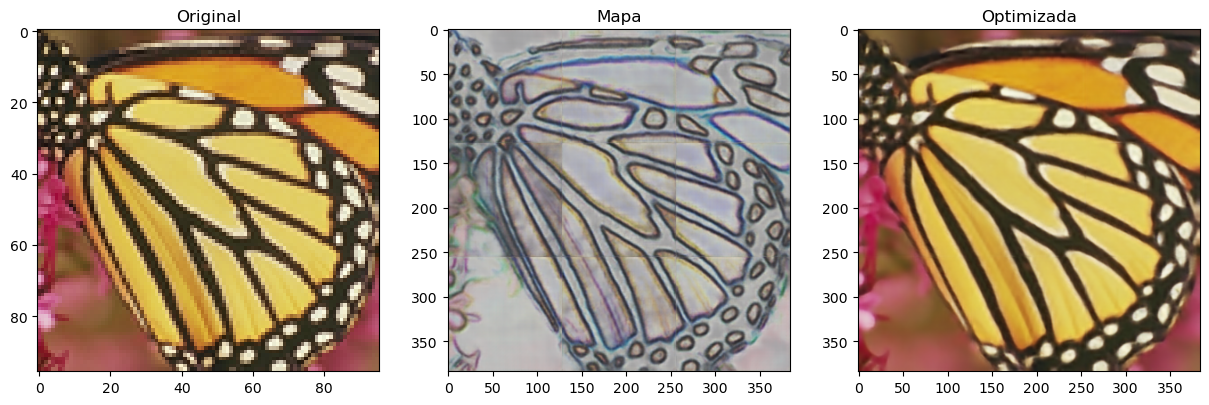

In [55]:
def RODIUCAN_aplicar_modeloAC_a_imagenesRGB_COMBINADAColor(xmodelo1,xmodelo2,img_reducida,n_repetir_modelo2=0):
    #Reducir el ruido gaussiano en la imagen
    #Puede reducirse un poco el ruido para obtener una mejor deteccion de bordes, a costa de sacrificar un poco de detalle en texturas.
    #img_reducida=cv2.fastNlMeansDenoisingColored(img_reducida,None,2,2,7,21)
    
    xdata_img_reducida_array_nor=convertir_imagen_a_parches_normalizarColor(img_reducida)
    #Aplicar modelo RNA
    decoded_maps = xmodelo1(xdata_img_reducida_array_nor).numpy()        
    img_mapa=unir_parches_en_imagenColor(decoded_maps,img_reducida[:,:,0])
    #-----------------------
    xdata_img_mapa_array_nor=convertir_imagen_a_parches_normalizarColor(img_mapa)
    xtqdata_img_RyM_array_nor=unirDatosImagen(xdata_img_reducida_array_nor,xdata_img_mapa_array_nor)
    for k in range(0,n_repetir_modelo2):
        decoded_imgs = xmodelo2(xtqdata_img_RyM_array_nor).numpy()
        ximagen=unir_parches_en_imagenColor(decoded_imgs,img_reducida[:,:,0])
        xdata_img_reducida_array_nor=convertir_imagen_a_parches_normalizarColor(ximagen)
        xtqdata_img_RyM_array_nor=unirDatosImagen(xdata_img_reducida_array_nor,xdata_img_mapa_array_nor)
    decoded_imgs = xmodelo2(xtqdata_img_RyM_array_nor).numpy()
    ximagen=unir_parches_en_imagenColor(decoded_imgs,img_reducida[:,:,0])
        
    #Aplicar el modelo a la imagen con bordes ampliados
    ximagenDD=get_aplicar_modeloAC_a_imagenes_DD_COMBINADAColor(xmodelo1,xmodelo2,img_reducida,n_repetir_modelo2)
        
    ximagenR=ajustarBrillo(ximagen[:,:,0],img_mapa[:,:,0])
    ximagenR=difuminarBordes(ximagenR,img_mapa[:,:,0])
    ximagenR=combinarBordesDD(ximagenR,ximagenDD[:,:,0])
        
    ximagenG=ajustarBrillo(ximagen[:,:,1],img_mapa[:,:,1])
    ximagenG=difuminarBordes(ximagenG,img_mapa[:,:,1])
    ximagenG=combinarBordesDD(ximagenG,ximagenDD[:,:,1])
        
    ximagenB=ajustarBrillo(ximagen[:,:,2],img_mapa[:,:,2])
    ximagenB=difuminarBordes(ximagenB,img_mapa[:,:,2])
    ximagenB=combinarBordesDD(ximagenB,ximagenDD[:,:,2])
    
    #Unir los 3 canales de la imagen
    ximagen=np.zeros((ximagenR.shape[0],ximagenR.shape[1],3))
    ximagen[:,:,0]=ximagenR[:,:]
    ximagen[:,:,1]=ximagenG[:,:]
    ximagen[:,:,2]=ximagenB[:,:]
    yimagen=ximagen.astype(np.uint8)
    return img_mapa,yimagen
        
def optimizar(img,n_repetir_modelo2=0):
    original_tamy=img.shape[0]
    original_tamx=img.shape[1]
    #Redimensionar a multiplo 128x128
    tamsegy=int((img.shape[0]*4)/TAM_PARCHE)
    tamsegx=int((img.shape[1]*4)/TAM_PARCHE)
    nuevoy=tamsegy*TAM_PARCHE
    nuevox=tamsegx*TAM_PARCHE
    if(nuevoy<TAM_PARCHE):
        nuevoy=TAM_PARCHE
    if(nuevox<TAM_PARCHE):
        nuevox=TAM_PARCHE
    #Puede usarse el redimensionamiento por interpolación bicubica o vecinos mas cercanos
    img2 = cv2.resize(img, dsize=(nuevox,nuevoy), interpolation=cv2.INTER_CUBIC)    
    #img2 = cv2.resize(img, dsize=(nuevox,nuevoy), interpolation=cv2.INTER_NEAREST)
    
    xxnomarchivo='redautoencoderEB128RGB.h5'
    redautoencoder_eb_rgb=RedAutoencoderEB_RGB()
    redautoencoder_eb_rgb.load_weights(directorio_salida+xxnomarchivo)
    
    xxnomarchivo='redautoencoderAC2_128RGB.h5'
    redautoencoder_rgb=RedAutoencoder_RGB()
    redautoencoder_rgb.load_weights(directorio_salida+xxnomarchivo)
    
    img_map,img_res=RODIUCAN_aplicar_modeloAC_a_imagenesRGB_COMBINADAColor(redautoencoder_eb_rgb,redautoencoder_rgb,img2,n_repetir_modelo2)
    img_res = cv2.resize(img_res, dsize=(original_tamx*4,original_tamy*4), interpolation=cv2.INTER_CUBIC)
    return img,img_map,img_res

img = cv2.imread('prueba001.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

imgOriginal,imgMapa,imgOptimizada=optimizar(img,0)

tablag=plt.figure(figsize=(15, 15))
c1=tablag.add_subplot(1,3,1)
plt.title('Original')
plt.imshow(imgOriginal)

c1=tablag.add_subplot(1,3,2)
plt.title('Mapa')
plt.imshow(imgMapa)

c1=tablag.add_subplot(1,3,3)
plt.title('Optimizada')
plt.imshow(imgOptimizada)

# Con interfaz gradio usando Interface

In [50]:
#ent=gr.Image(shape=(200, 200))
demo = gr.Interface(fn=optimizar, inputs=gr.Image(), outputs=["image","image","image"], examples=["prueba001.png","prueba006.png","prueba015.png"])
demo.launch()

Running on local URL:  http://127.0.0.1:7881

To create a public link, set `share=True` in `launch()`.


# Con interfaz gradio usando bloques

In [54]:
with gr.Blocks() as demo:
    #ent=gr.Image(shape=(200, 200))
    ent=gr.Image()
    #inp = gr.Textbox(label="Repetir")
    inp = gr.Slider(0, 5,value=0,step=1,label="Repetir")
    gr.Examples(["prueba001.png","prueba006.png","prueba015.png"],inputs=ent)
    with gr.Row():
        s1=gr.Image(label="Original")
        s2=gr.Image(label="Mapa")
        s3=gr.Image(label="Optimizada")
    btn = gr.Button(value="Submit")
    
    btn.click(optimizar, inputs=[ent,inp], outputs=[s1,s2,s3])

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7885

To create a public link, set `share=True` in `launch()`.
